# Appendix D
I am using "The Pit and the Pendulum" by Edgar Allan Poe (which is in the public domain) instead of "The Verdict" to get some novel results.

In [1]:
# Reinitialize the model
import torch
from previous_chapters import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [2]:
# Import the text data
file_path = "pit-and-pendulum.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [3]:
# Load the text data into the data loaders
from previous_chapters import create_dataloader_v1
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0)
val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0)

# D.1 - Learning rate warmup

In [4]:
# Prepare the warmup
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01
# warmup_steps = 20
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(warmup_steps)

39


In [5]:
# Implement a simple training loop
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1
track_lrs = []
for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

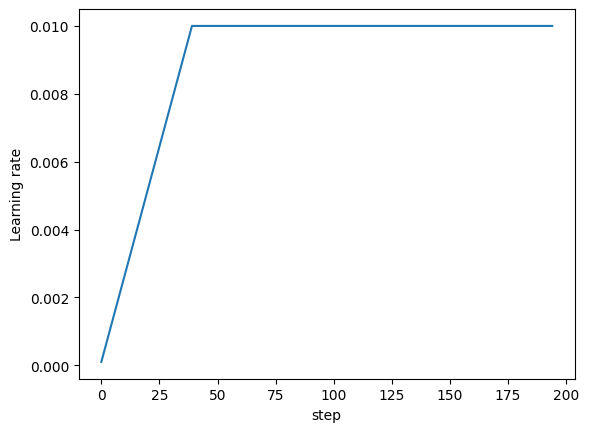

In [6]:
# Visualize how the learning rate was changed
import matplotlib.pyplot as plt
plt.ylabel("Learning rate")
plt.xlabel("step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.show()

# D.2 - Cosine decay

In [7]:
# Prepare the cosine decay
import math
min_lr = 0.1 * initial_lr
track_lrs = []
lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

In [8]:
# Modify the training loop by adding cosine decay
for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment  
        else:
            progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

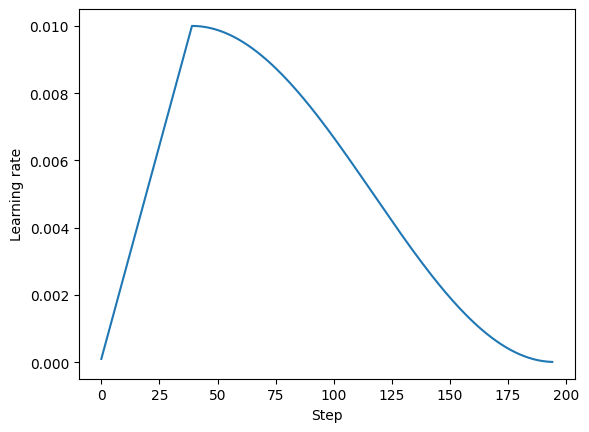

In [9]:
# Verify the learning rate has changed as intended
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.show()

# D.3 Gradient clipping

In [10]:
# Initialize a new model
from previous_chapters import calc_loss_batch
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [11]:
# Identify the highest gradient value
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad
print(find_highest_gradient(model))

tensor(0.0505)


In [12]:
# Apply gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
print(find_highest_gradient(model))

tensor(0.0203)


# D.4 - The modified training function

In [13]:
# Improve the training function
from previous_chapters import evaluate_model, generate_and_print_sample
def train_model(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1
    peak_lr = optimizer.param_groups[0]["lr"]
    total_training_steps = len(train_loader) * n_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1
            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment 
            else:
                progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            if global_step >= warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Iter {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen, track_lrs

In [14]:
# Train the model
import tiktoken
import time
start_time = time.time()
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
peak_lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")
n_epochs = 10 # Changed this to save time and stay consistent with Chapter 5
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="So far, I had",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Iter 000000): Train loss 10.927, Val loss 10.940
Ep 1 (Iter 000005): Train loss 9.298, Val loss 9.546
Ep 1 (Iter 000010): Train loss 8.127, Val loss 8.644
So far, I had the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (Iter 000015): Train loss 7.258, Val loss 7.731
Ep 2 (Iter 000020): Train loss 6.232, Val loss 7.252
Ep 2 (Iter 000025): Train loss 6.179, Val loss 7.403
So far, I had,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000030): Train loss 6.235, Val loss 7.544
Ep 3 (Iter 000035): Train loss 19.254, Val loss 18.262
So far, I had a a a a a a                                            
Ep 4 (Iter 000040): Train loss 6.273, Val loss 7.783
Ep 4 (Iter 000045): Train loss 5.908, Val loss 7.813
Ep 4 (Iter 000050): Train loss 6.159, Val loss 7.802
So far, I had,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
E

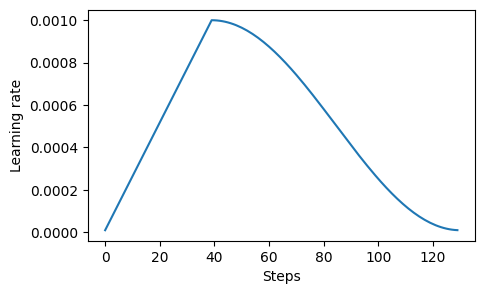

In [15]:
# Check the learning rate
plt.figure(figsize=(5, 3))
plt.plot(range(len(lrs)), lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

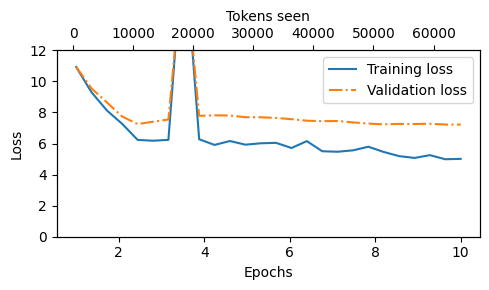

In [19]:
# Plot the losses
from previous_chapters import plot_losses
epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.ylim(0, 12)
plt.show()